# **Pré-traitements et Exploration**

## **Récupération des données**

Les données ont été récupérées sur le [*StackExchange Data Explorer*](https://data.stackexchange.com/stackoverflow/query/new) où il est possible d'effectuer une requête sur la base SQL du site, puis de télécharger ces dernières au format CSV.

Afin de récupérer des données de qualité, certains critères ont été appliqués pour filtrer les questions : 

- Données récentes (depuis 2022) : les usages et les technologies évoluent rapidement.
- Le score doit être positif.
- Au moins une réponse.
- Au moins un commentaire.
- L'utilisateur doit avoir une réputation au moins égale à la moyenne.

La réputation des utilisateurs est définit selon plusieurs paramètres (question ou réponses qui ont obtenus des votes, réponses marquées comme acceptées, etc.), détails du calcul sur [cette page](https://stackoverflow.com/help/whats-reputation).

<div class="alert alert-info">
Il est important de récupérer des questions qui ont reçu une certaine approbation de la communauté, provenant d'utilisateurs expérimentés. De cette manière les tags associés pourront être considérés comme qualitatifs et seront donc plus appropriés à l'entraînement d'un modèle supervisé.
</div>

Voici le code utilisé pour la requête :
<br><br>

```SQL
SELECT TOP(50000) posts.id,
                  posts.creationdate,
                  title,
                  body,
                  tags,
                  users.reputation,
-- Réputation moyenne des users avec les critères actuels
                  (SELECT Avg(reputation)
                   FROM   users) AS moyenne_reputation
FROM   posts
-- Jointure pour récupérer la réputation des users
       JOIN users
         ON posts.owneruserid = users.id
WHERE  posts.creationdate BETWEEN CONVERT(DATETIME, '2022-01-01') AND
                                         CONVERT(DATETIME, '2023-12-31')
       AND posts.score > 0 -- Questions avec un score positif
       AND posts.answercount > 0 -- Au moins une réponse
       AND posts.commentcount > 0 -- Au moins un commentaire
       AND users.reputation >= 91 -- Soit la réputation moyenne sur cette période avec ces critères
```


Réponse serveur : *"50000 rows returned in 3102 ms"*

## **Importation des bibliothèques**

In [1]:
import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re  # Lors des traitements des textes

from bs4 import BeautifulSoup  # Pour nettoyer les balises HTML

import spacy

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud




C:\Users\Data Science\AppData\Roaming\Python\Python310\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Data Science\AppData\Roaming\Python\Python310\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Data Science\AppData\Roaming\Python\Python310\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Data Science\AppData\Roaming\Python\Python310\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


## **Importation des données**

In [2]:
print("Importation du dataset...")
colonnes_a_importer = ['creationdate', 'title', 'body', 'tags', 'reputation']
data = pd.read_csv("QueryResults.csv", sep=',', usecols=colonnes_a_importer)
print("Importation terminée.")

Importation du dataset...
Importation terminée.


- Affichage de 20 lignes au hasard : 

In [3]:
data.sample(20)

,creationdate,title,body,tags,reputation
2310,2022-07-20 13:22:36,what does it mean to have these kind of errors...,<p>this is my solution</p>\n<pre><code>#includ...,<c><duplicates><char><c-strings><function-defi...,531
44768,2022-03-08 21:56:25,Golang - get list of files from a shared Googl...,<p>I am trying to list files and their IDs fro...,<go><google-drive-api>,1419
41423,2023-08-10 17:02:28,Extract in which sequence a loop created an error,<p>I have a loop to test different values in a...,<r>,109
5009,2022-07-30 18:04:25,Transitions not working inside NavigationView,<p>I am trying to navigate between two views w...,<ios><swift><swiftui><swiftui-navigationview><...,1227
24441,2023-03-25 20:50:15,Simics qsp-x86 change default network adapter,<p>I'm porting an hobby OS I wrote under QEMU ...,<simics>,157
40287,2023-08-06 08:33:16,write_buffer doesn't write to buffer instead o...,<p>Hello I have recently began learning comput...,<rust><webgpu><wgpu-rs>,379
33811,2023-05-30 13:15:35,Errbit can't verify CSRF token authenticity fo...,<p>We've just upgraded our Errbit app (<a href...,<ruby-on-rails><errbit>,28025
29901,2023-04-25 21:50:25,WatchOS Complication Flashing,<p>I am making a very simple WidgetKit complic...,<ios><apple-watch><watchos><widgetkit>,487
47384,2023-09-18 14:48:49,Cartalyst Stripe (PHP) advice required,<p>Everything I read seems to be about Laravel...,<php><stripe-payments><cartalyst>,558
34478,2023-06-17 01:54:56,Build Constraints restricting fyne import for ...,"<p>I have imported the fyne GUI , and now my ...",<go><import><constraints><fyne>,109


### **Traîtements de base**

- Conversion de la colonne date au format date : 

In [4]:
data["creationdate"] = pd.to_datetime(data["creationdate"])

- Vérification du type des colonnes : 

In [5]:
data.dtypes

creationdate    datetime64[ns]
title                   object
body                    object
tags                    object
reputation               int64
dtype: object

- Y a-t-il des doublons ?

In [6]:
for col in data.columns:
    n = data.duplicated(subset=col).sum()
    print(f"Colonne '{col}' : {n} doublon(s)")

Colonne 'creationdate' : 91 doublon(s)
Colonne 'title' : 0 doublon(s)
Colonne 'body' : 1 doublon(s)
Colonne 'tags' : 14871 doublon(s)
Colonne 'reputation' : 42320 doublon(s)


- Il y a un doublon dans la colonne 'body' : 

In [7]:
data.loc[data['body'].duplicated(keep=False) == True]

,creationdate,title,body,tags,reputation
13995,2022-09-03 20:36:16,Remove nodeSelectorTerms param in manifest dep...,<p>I use this manifest configuration to deploy...,<kubernetes><kubernetes-helm>,1198
16003,2022-09-15 23:08:29,Remove nodeSelectorTerms param,<p>I use this manifest configuration to deploy...,<kubernetes>,1198


- Suppression de ce doublon (les doublons dans les autres colonnes ne sont pas problématiques) : 

In [8]:
data.drop_duplicates(subset='body', inplace=True)

- y a-t-il des valeurs manquantes ?

In [9]:
data.isna().sum()

creationdate    0
title           0
body            0
tags            0
reputation      0
dtype: int64

### **Création d'une nouvelle colonne *'corpus'***

Nos données textuelles sont contenues dans *'title'* (le titre de la question) et *'body'* (le corps de la question).<br>
Il peut être intéressant de conserver le titre car des informations importantes peuvent s'y trouver, sans qu'elles soient obligatoirement reprise dans le corps du message.

In [10]:
data['corpus'] = data['title'] + ' ' + data['body']

- On enlève *'title'* et *'body'* dont on a plus besoin : 

In [11]:
data.drop(['title', 'body'], axis=1, inplace=True)

### **Formattage des tags**

Plutôt que d'avoir "<Tag 1><Tag 2>", on souhaite avoir [Tag 1, Tag 2]

- Avant formattage : 

In [12]:
data[['tags']]

,tags
0,<antlr4>
1,<reactjs><firebase><jestjs>
2,<async-await><concurrency><hacklang>
3,<typescript>
4,<expo><google-play-console><google-play-develo...
...,...
49995,<ionic-framework><ionic-react>
49996,<stripe-payments>
49997,<terraform>
49998,<azure><azurite>


In [13]:
data['tags'] = data['tags'].apply(lambda x: re.findall(r'<(.*?)>', x))

- Après formattage : 

In [14]:
data[['tags']]

,tags
0,[antlr4]
1,"[reactjs, firebase, jestjs]"
2,"[async-await, concurrency, hacklang]"
3,[typescript]
4,"[expo, google-play-console, google-play-develo..."
...,...
49995,"[ionic-framework, ionic-react]"
49996,[stripe-payments]
49997,[terraform]
49998,"[azure, azurite]"


### **Suppression des balises HTML dans le corpus**

Les questions contiennent des balises HTML qui vont perturber nos traitements, il faut les enlever.<br>
Nous allons utiliser pour cela le parser HTML de *BeautifulSoup*.

- Premier document avant traitement : 

In [15]:
data.loc[0]['corpus']

'Lexer rule to handle escape of quote with quote or backslash in ANTLR4? <p>I\'m trying to expand the answer to <a href="https://stackoverflow.com/questions/29800106/how-do-i-escape-an-escape-character-with-antlr-4">How do I escape an escape character with ANTLR 4?</a> to work when the &quot; can be escaped both with &quot; and \\. I.e. both</p>\n<pre><code>&quot;Rob &quot;&quot;Commander Taco&quot;&quot; Malda is smart.&quot;\n</code></pre>\n<p>and</p>\n<pre><code>&quot;Rob \\&quot;Commander Taco\\&quot; Malda is smart.&quot;\n</code></pre>\n<p>are both valid and equivalent. I\'ve tried</p>\n<pre><code>StringLiteral : \'&quot;\' (\'&quot;&quot;\'|\'\\\\&quot;\'|~[&quot;])* \'&quot;\';\n</code></pre>\n<p>but if fails to match</p>\n<pre><code>&quot;Entry Flag for Offset check and for \\&quot;don\'t start Chiller Water Pump Request\\&quot;&quot;\n</code></pre>\n<p>with the tokenizer consuming more characters than intended, i.e. consumes beyond \\&quot;&quot;</p>\n<p>Anyone who knows how 

In [16]:
debut = time.time()  # Heure de début du traitement

data['corpus'] = data['corpus'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

print(f"Durée du traitement : {(time.time() - debut):.2f}")

Durée du traitement : 31.82


- Premier document après traitement : 

In [17]:
data.loc[0]['corpus']

'Lexer rule to handle escape of quote with quote or backslash in ANTLR4? I\'m trying to expand the answer to How do I escape an escape character with ANTLR 4? to work when the " can be escaped both with " and \\. I.e. both\n"Rob ""Commander Taco"" Malda is smart."\n\nand\n"Rob \\"Commander Taco\\" Malda is smart."\n\nare both valid and equivalent. I\'ve tried\nStringLiteral : \'"\' (\'""\'|\'\\\\"\'|~["])* \'"\';\n\nbut if fails to match\n"Entry Flag for Offset check and for \\"don\'t start Chiller Water Pump Request\\""\n\nwith the tokenizer consuming more characters than intended, i.e. consumes beyond \\""\nAnyone who knows how to define the lexer rule?\n\nA bit more detail...\n\n"" succeeds\n"""" succeeds\n\\" " succeeds\n"\\"" succeeds (at EOF)\n"\\""\\n"" fails (it greedily pulls in the \\n and "\n\nExample: (text.txt)\n""\n""""\n"\\" "\n"\\""\n""\n\ngrun test tokens -tokens < test.txt\n\nline 5:1 token recognition error at: \'"\'\n[@0,0:1=\'""\',<StringLiteral>,1:0]\n[@1,2:2=\'\\

## **Exploration des données**

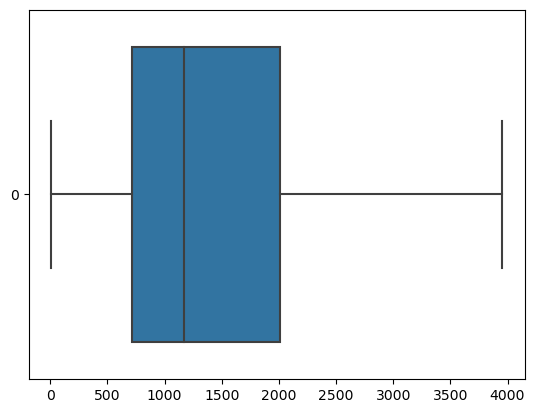

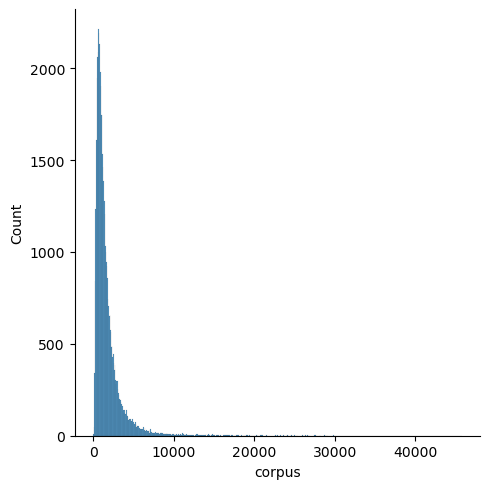

In [18]:
# Longueur des questions
tmp = data.corpus.str.len()
sns.boxplot(tmp, orient='h', showfliers=False)

sns.displot(tmp)

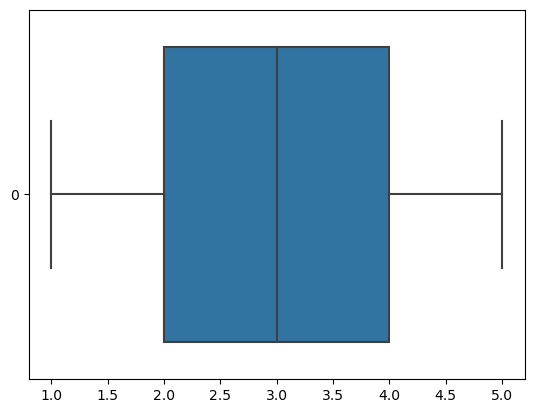

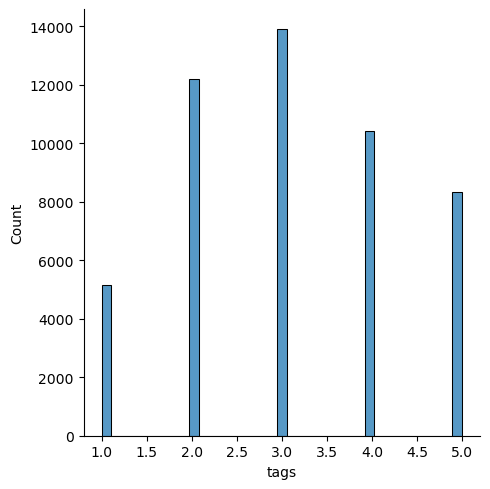

In [19]:
# nombre de tags
tmp = data.tags.str.len()
sns.boxplot(tmp, orient='h')

sns.displot(tmp)

In [20]:
# création de 2 nouvelles variables pour l'exploration

data['question_lenth'] = data.corpus.str.len()
data['tags_number'] = data.tags.str.len()

<Axes: >

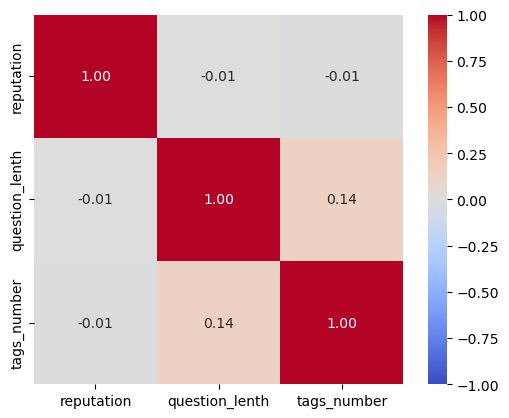

In [21]:
# corrélations entre les variables numériques

corr = data.corr(numeric_only=True)
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", square=True)

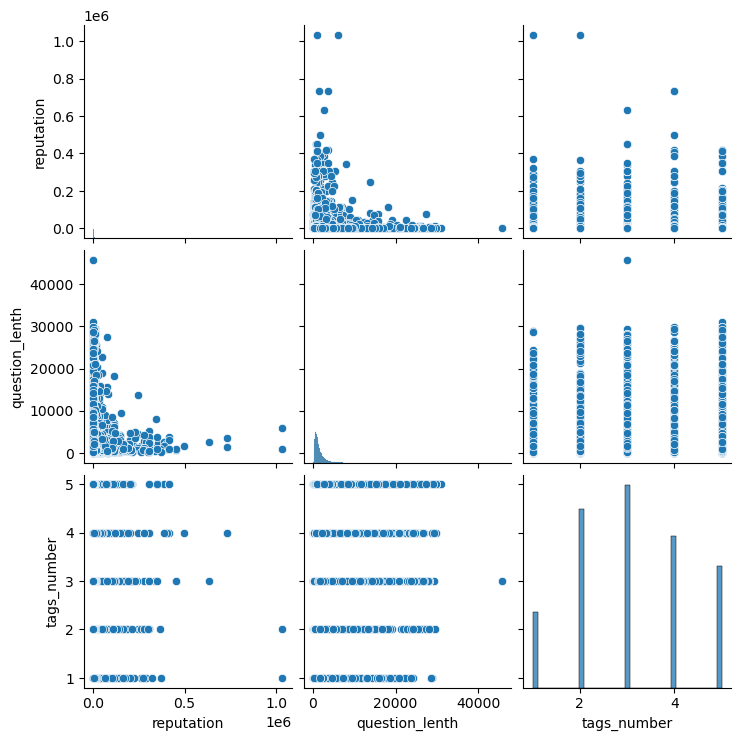

In [22]:
sns.pairplot(data)

In [23]:
data

,creationdate,tags,reputation,corpus,question_lenth,tags_number
0,2022-05-08 20:40:40,[antlr4],129,Lexer rule to handle escape of quote with quot...,2387,1
1,2022-05-08 21:22:05,"[reactjs, firebase, jestjs]",121,"Firebase - Testing with Jest throws error ""INT...",3971,3
2,2022-05-08 21:49:08,"[async-await, concurrency, hacklang]",307,Concurrent block in hacklang Since hack is a s...,243,3
3,2022-05-08 21:49:57,[typescript],1436,Can you set a type for a function in typescrip...,1374,1
4,2022-05-08 21:51:00,"[expo, google-play-console, google-play-develo...",4346,"Expo EAS Submit, where to store service accoun...",595,3
...,...,...,...,...,...,...
49995,2022-03-21 09:01:04,"[ionic-framework, ionic-react]",590,Ionic-React App Automatically Changing to Dark...,481,2
49996,2022-03-21 09:02:39,[stripe-payments],125,is it possible to operate two service in the o...,307,1
49997,2022-03-21 09:02:54,[terraform],4200,Which security problem does terraform Checksum...,1621,1
49998,2022-03-21 13:54:21,"[azure, azurite]",135,Visual studio 2022 with azurite integrated (v3...,1716,2


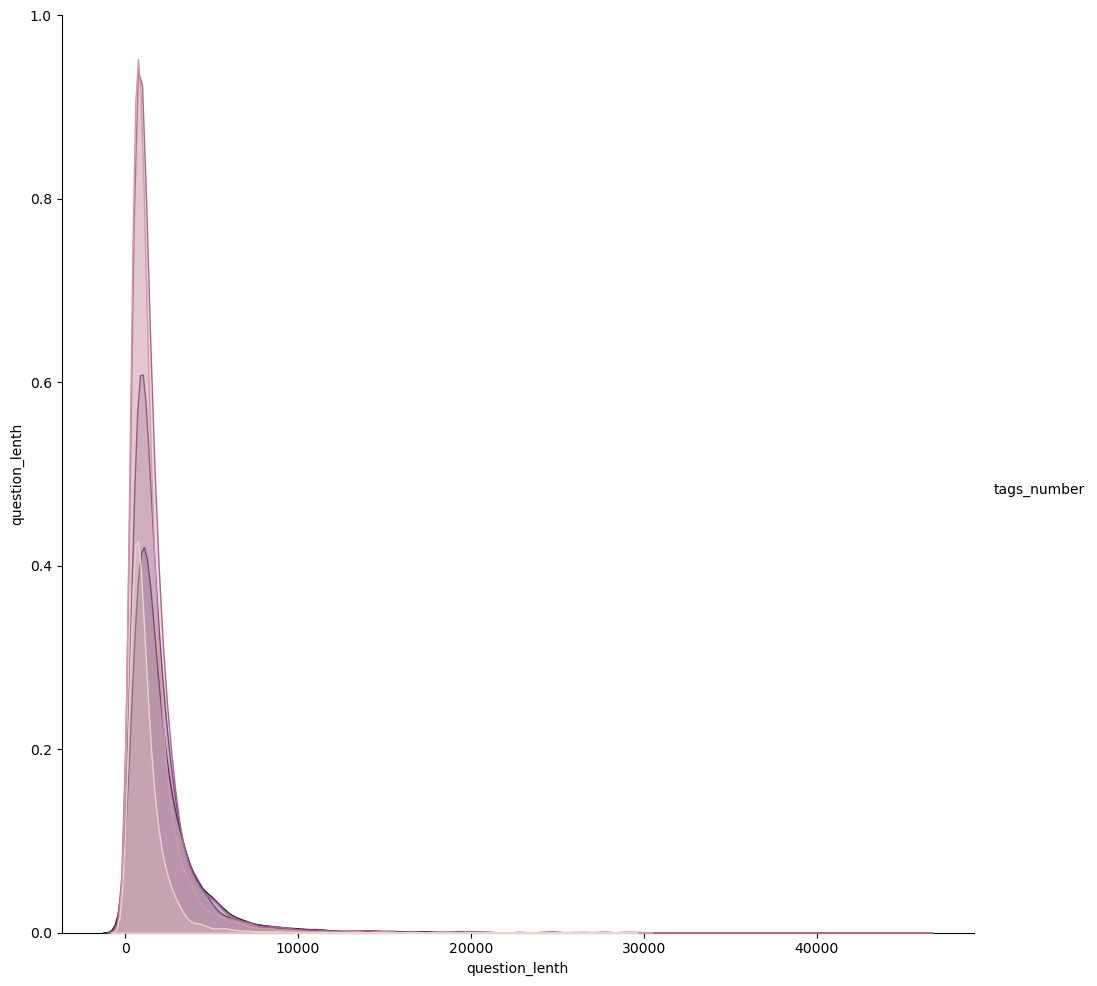

In [24]:
sns.pairplot(data[['question_lenth', 'tags_number']], hue="tags_number", height=10)

In [25]:
for idx, ser in data.sample(5).iterrows():
    txt_1 = f"Tags : {ser['tags']}\n"
    print(txt_1 + ser['corpus']+ "..." + "\n")

Tags : ['r', 'parallel-coordinates', 'echarts4r']
How to show labels on the left side of the vertical line in a parallel coordinates plot created with echarts4r? The context
I know the following code produces the following plot
library('echarts4r')

dat  <- structure(list(
  labels = c("string4",
             "string3",
             "string2",
             "string1"),
  quantity = c(19L,
               10L,
               15L,
               20L)),
  row.names = 4:1,
  class = "data.frame")

dat <- dat[order(dat$labels, decreasing = TRUE),]

dat |>
  e_charts(y  = labels, reorder = FALSE) |>
  e_parallel(labels, quantity, opts = list(smooth = TRUE))


The question
I want these labels (the ones pointed by the blue arrows) to be shown on the left instead of on the right of the vertical line. How can I move them to the left side?

What I've tried
I've taken a look at the documentation, as suggested by @socialscientist in its answer, and I've tried the following to no avail.
The following 

# explo faire gaphique avec creationdate

## **Text processing**

### **Commençons par analyser le corpus dans sa globalité**

- Fonctions de base : 

In [26]:
def display_tokens_infos(tokens):
    """Infos de base d'un corpus"""

    print(f"Nombre de tokens : {len(tokens)}\nNombre de tokens uniques : {len(set(tokens))}")
    print(f"10 premiers tokens : {tokens[:10]}")

In [27]:
def basic_cleaning(doc):
    """Cleaning de base"""

    # Passage en minuscule
    doc = doc.lower().strip()  # .strip() enlève le/les caractère(s) définis à gauche et à droite (espace par défaut)

    # Tokenisation avec NLTK
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Suppression des stop words
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Suppression des caractères numériques
    alpha_tokens = [w for w in cleaned_tokens_list if w.isalpha()]
   
    return alpha_tokens

- Définition des stopwords que l'on va utiliser : 

In [28]:
stop_words = set(stopwords.words('english'))

- Création d'un corpus global en fusionnant toutes les données de la colonne ```data['corpus']``` : 

In [29]:
raw_corpus = " ".join(data.corpus.values)
print(f"Le corpus global fait {len(raw_corpus)} caractères.")

Le corpus global fait 88420862 caractères.


- Tokenisation et nettoyage de base : 

In [30]:
corpus = basic_cleaning(raw_corpus)
display_tokens_infos(corpus)

Nombre de tokens : 7156445
Nombre de tokens uniques : 199120
10 premiers tokens : ['lexer', 'rule', 'handle', 'escape', 'quote', 'quote', 'backslash', 'trying', 'expand', 'answer']


- Fréquence des tokens : 

In [31]:
# On fait le compte des différents tokens
tmp = pd.Series(corpus).value_counts()

print("Tokens les plus fréquents : ")
display(tmp.head(10))

print("Tokens les moins fréquents : ")
display(tmp.tail(10))

print("Distribution des présences des tokens : ")
display(tmp.describe())


Tokens les plus fréquents : 


data      39741
class     38501
error     38058
c         35776
return    34349
using     34213
string    34200
code      34042
name      33775
type      33380
dtype: int64

Tokens les moins fréquents : 


asyncwebserverrequest    1
espasyncserver           1
officenumber             1
cellnumber               1
glazed                   1
oldfile                  1
asserthalt               1
vinit                    1
customauth               1
systemsmanager           1
dtype: int64

Distribution des présences des tokens : 


count    199120.000000
mean         35.940363
std         500.875301
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max       39741.000000
dtype: float64

La distribution est très asymétrique : 
- au moins 25% des tokens sont présents une seule fois.
- 50% des tokens spont présents 2 fois ou moins

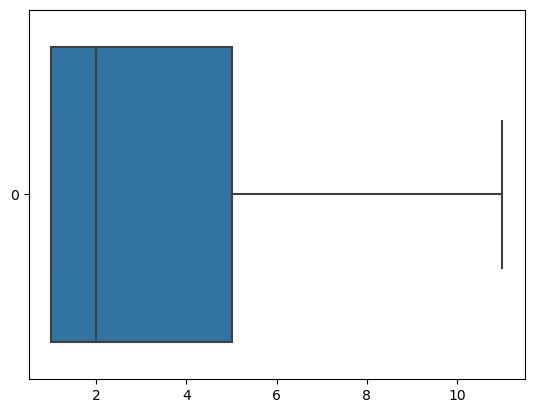

In [32]:
sns.boxplot(tmp, orient='h', showfliers=False);


- Mots rares : <br>

Pour un mot unique, il y a de grandes chances soit qu'il soit éliminé lors de méthodes de réduction de dimentionnalité, soit qu'il ne puisse pas être utilisé comme dimention.<br>
Et pour accélérer nos calculs futurs, on a tout intérêt à diminuer la liste de tokens de notre corpus, et donc à supprimer les tokens présents une seule fois.

In [33]:
list_unique_words = tmp[tmp==1]
list_unique_words = list(list_unique_words.index)  # .index = pour ne récupérer que les mots
print(f"Nombre de mots rares : {len(list_unique_words)}")
print(f"Exemples de mots rares : {list_unique_words[:10]}")

Nombre de mots rares : 73233
Exemples de mots rares : ['inod', 'jwtgeneratorservicefixture', 'promp', 'dispear', 'testthree', 'hcryptkey', 'codelensfontsize', '新しく新着情報を書く', 'inva', '新着情報記事を書く']


- Mots présents 5 fois ou moins : 

On peut faire de même avec les mots présents 5 fois ou moins.

In [34]:
list_min_5_words = tmp[tmp<=5]
list_min_5_words = list(list_min_5_words.index)  # .index = pour ne récupérer que les mots
print(f"Nombre de mots présents 5 fois ou moins : {len(list_min_5_words)}")
print(f"Exemples de mots : {list_min_5_words[:10]}")

Nombre de mots présents 5 fois ou moins : 153617
Exemples de mots : ['finicio', 'valafterarrnonref', 'managementclient', 'buildcontexts', 'testerimpl', 'cmsamplebuffer', 'midnightblue', 'mapraterequestasync', 'mouseeventhandler', 'libminizip']


Il y en a deux fois plus que de mots uniques.

- Intérêt de traiter les mots présents 10 fois ou moins ?

In [35]:
print(f"Nombre de mots présents 10 fois ou moins : {len(tmp[tmp<=10])}")

Nombre de mots présents 10 fois ou moins : 172377


La différence avec les mots présents 5 fois ou moins n'est pas très grande.

### **Lemmatisation : comparaison de NLTK et Spacy**

- Exemple de phrase à lemmatiser : 

In [36]:
phrase = "These are sentences going to be translated"
tokenizer = RegexpTokenizer(r"\w+")
phrase_tokens = tokenizer.tokenize(phrase)

- Lemmatisation avec NLTK : 

In [37]:
# Instanciation
wordNetLemmatizer = WordNetLemmatizer()

debut = time.time()  # Heure de début du traitement
lemmaWords1 = [wordNetLemmatizer.lemmatize(word) for word in phrase_tokens]
print(f"Durée du traitement : {(time.time() - debut):.2f}")

print(f'Tokens after Lemmatization using WordNet Lemmatizer: \n{phrase} => {lemmaWords1}')

Durée du traitement : 1.32
Tokens after Lemmatization using WordNet Lemmatizer: 
These are sentences going to be translated => ['These', 'are', 'sentence', 'going', 'to', 'be', 'translated']


- Lemmatisation avec Spacy : 

In [38]:
# Instanciation
spacy_nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])  # 'parser' et 'ner' pas utiles pour le moment

debut = time.time()  # Heure de début du traitement
doc = spacy_nlp(phrase)
print(f"Durée du traitement : {(time.time() - debut):.2f}")

lemmaWords2 = [word.lemma_ for word in doc]
print(f'Tokens after Lemmatization using SpaCy Lemmatization: \n{phrase} => {lemmaWords2}')

Durée du traitement : 0.00
Tokens after Lemmatization using SpaCy Lemmatization: 
These are sentences going to be translated => ['these', 'be', 'sentence', 'go', 'to', 'be', 'translate']


- Comparaison des deux résultats : 

In [39]:
print(phrase, "(Texte à lemmatiser)")
print(lemmaWords1, "(NLTK)")
print(lemmaWords2, "(Spacy)")

These are sentences going to be translated (Texte à lemmatiser)
['These', 'are', 'sentence', 'going', 'to', 'be', 'translated'] (NLTK)
['these', 'be', 'sentence', 'go', 'to', 'be', 'translate'] (Spacy)


NLTK a juste mis *sentences* au singulier, alors que Spacy a en plus donné la racine des mots *are*, *going* et *translated*.<br>
Le lemmatiseur de Spacy semble plus efficace, c'est celui-ci que nous utiliserons.

In [40]:
# Space prend en entrée un string
ecrase = ' '.join(corpus[:25000])

# Instanciation
spacy_nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])  # 'parser' et 'ner' pas utiles pour le moment

debut = time.time()  # Heure de début du traitement
doc = spacy_nlp(ecrase)
print(f"Durée du traitement : {(time.time() - debut):.2f}")

lemmaWords2 = [word.lemma_ for word in doc]


Durée du traitement : 1.70


In [41]:
len(corpus)

7156445

In [42]:
len(set(corpus[:100000]))

11110

In [43]:
len(set(lemmaWords2))

3799

In [44]:
display_tokens_infos(corpus)

Nombre de tokens : 7156445
Nombre de tokens uniques : 199120
10 premiers tokens : ['lexer', 'rule', 'handle', 'escape', 'quote', 'quote', 'backslash', 'trying', 'expand', 'answer']


In [45]:
debut = time.time()  # Heure de début du traitement

print(f"Durée du traitement : {(time.time() - debut):.2f}")

Durée du traitement : 0.00


In [46]:
def lem_colonne(texte):
    doc = spacy_nlp(texte)
    lemmaWords2 = set([word.lemma_ for word in doc])
    return lemmaWords2

In [47]:
data_lem_test = data['corpus'][:1].apply(lem_colonne)
data_lem_test

0    {*, lexer, >, would, the, fail, can, rule, rea...
Name: corpus, dtype: object

In [48]:
len(data_lem_test[0])

211

In [49]:
data_lem_test[0]

{'\n',
 '\n\n',
 '\n\n\n',
 '\n\n\n\n\n',
 '\n    ',
 ' ',
 '           ',
 '"',
 "'",
 "'ve",
 '(',
 ')',
 '):',
 '*',
 ',',
 '-"-',
 '-\\-',
 '-token',
 '-ε-',
 '.',
 '...',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '1:2',
 '2',
 '2:1',
 '2:4',
 '3:5',
 '4',
 '5',
 '5:1',
 '6',
 '7',
 '9',
 ':',
 ';',
 '<',
 '>',
 '?',
 '@0,0:1=\'""\',<stringliteral>,1:0',
 '@0,0:5=\'"\\""\\n"\',<stringliteral>,1:0',
 "@1,2:2='\\n",
 "@1,7:6='<eof>',<eof>,2:2",
 '@2,3:6=\'""""\',<stringliteral>,2:0',
 "@3,7:7='\\n",
 '@4,8:12=\'"\\',
 "@5,13:13='\\n",
 '@6,14:19=\'"\\""\\n"\',<stringliteral>,4:0',
 "@7,21:20='<eof>',<eof>,5:2",
 'ANTLR',
 'ANTLR4',
 'ATN',
 'Chiller',
 'Commander',
 'EOF',
 'Entry',
 'Flag',
 'Grammar',
 'I',
 'I.e.',
 'Lexer',
 'Malda',
 'More',
 'Offset',
 'Pump',
 'Request\\',
 'Rob',
 'State',
 'StringListeral',
 'StringLiteral',
 'Taco',
 'Taco\\',
 'Test',
 'WS',
 'Water',
 '[',
 '\\',
 '\\""\\n',
 '\\"Commander',
 '\\"don\'t',
 '\\.',
 '\\\\',
 '\\n',
 '\\t\\n\\r]+',
 '

### **Traitement des documents du corpus**

Voici les traitements que nous allons appliquer aux documents de *```data['corpus']```* : <br>

- Passer tous le texte en minuscule, afin de pouvoir regrouper les mots écrits avec des casses différentes.
- Exclure les mots rares, ceux qui sont présents une seule fois dans tout le corpus.
- Retrait des *Stop Words*, mots commun ayant peu d'intérêt dans le sens global des documents.
- Suppression des mots courts. Les mots très courts ne sont généralement pas ceux qui apportent le plus de sens.
- Suppression des données numériques. Elles ne nous intéressent pas ici.
- Lemmatisation. Afin de réduire la taille du vocabulaire, nous allons regrouper les déclinaisons d'un même mot en sa racine.




- Création de la fonction de traitement des documents : 

In [109]:
def process_documents(doc,
                   rejoin=False,
                   stop_words=None,
                   list_rare_words=None,
                   min_len_word=3,
                   alpha_only=True,
                   extra_words=None
                   ):
    
    """
    Docstring de la fonction
    """

    # Passage du texte en minuscules
    doc = doc.lower().strip()  # .strip() enlève le/les caractère(s) définis à gauche et à droite (espace par défaut)

    # Tokenisation du texte
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = set(tokenizer.tokenize(doc))  # set() pour supprimer les doublons

    # Suppression des stopwords (si fournis)
    if stop_words:
        cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]
    else:
        cleaned_tokens_list = raw_tokens_list

    # Suppression des mots rares (si fournis)
    if list_rare_words:
        non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]
    else:
        non_rare_tokens = cleaned_tokens_list

    # Suppression des mots courts
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # Suppression des caractères numériques (si l'option est activée)
    if alpha_only:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]  # isalpha() sert à retourner True s'il n'y a que des lettres, pas de chiffre
    else:
        alpha_tokens = more_than_N

    # Lemmatisation
    spacy_nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])  # 'parser' et 'ner' pas utiles pour le moment
    ecrase = ' '.join(alpha_tokens)  # Il faut "écraser" la liste pour qu'elle puisse passer dans le lemmatizer
    doc = spacy_nlp(ecrase)
    lemmatized = set([word.lemma_ for word in doc])  # set() pour supprimer d'éventuels nouveaux doublons qui auraient été créés

    # Suppression des extra_words (si fournis)
    if extra_words:
        final = [w for w in lemmatized if w not in extra_words]
    else:
        final = lemmatized

    # Forme des données retournées
    if rejoin:
        return " ".join(final) # retourne une unique chaine de caractère contenant les tokens séparés par un espace
    return final

In [97]:
def processor(doc):
    """Réalisation du traitement"""
    processed_docs = process_documents(doc,
                   rejoin=False,
                   stop_words=stop_words,
                   list_rare_words=list_unique_words,
                   min_len_word=3,
                   alpha_only=True,
                   extra_words=None
    )
    return processed_docs

In [100]:
data.corpus[:10]

0    Lexer rule to handle escape of quote with quot...
1    Firebase - Testing with Jest throws error "INT...
2    Concurrent block in hacklang Since hack is a s...
3    Can you set a type for a function in typescrip...
4    Expo EAS Submit, where to store service accoun...
5    Reliably and portably store and retrieve objec...
6    Why do we need to specify tsx while importing ...
7    Recursive Component returning property undefin...
8    Two ways of calling coroutines nestedly? Imagi...
9    How to make a button updating component dynami...
Name: corpus, dtype: object

In [101]:
processed = data.corpus[:10].apply(processor)
processed[0]

{'answer',
 'antlr',
 'anyone',
 'appear',
 'atn',
 'backslash',
 'behavior',
 'beyond',
 'bit',
 'bug',
 'change',
 'character',
 'check',
 'clear',
 'commander',
 'construct',
 'consume',
 'consuming',
 'continue',
 'define',
 'desire',
 'detail',
 'diagram',
 'differently',
 'end',
 'entry',
 'eof',
 'equivalent',
 'error',
 'escape',
 'example',
 'expand',
 'fail',
 'flag',
 'grammar',
 'greedily',
 'handle',
 'input',
 'instead',
 'intend',
 'know',
 'let',
 'lexer',
 'like',
 'line',
 'look',
 'malda',
 'match',
 'maybe',
 'miss',
 'must',
 'next',
 'offset',
 'order',
 'parallel',
 'path',
 'pull',
 'pump',
 'quote',
 'reach',
 'recognition',
 'request',
 'research',
 'rob',
 'rule',
 'see',
 'simplify',
 'small',
 'smart',
 'something',
 'start',
 'state',
 'stringliteral',
 'succeed',
 'taco',
 'test',
 'text',
 'token',
 'tokenizer',
 'tokens',
 'transition',
 'try',
 'txt',
 'unconsumed',
 'valid',
 'walk',
 'water',
 'work',
 'would'}

- Autre approche, en passant le corpus dans une liste

In [134]:
def process_documents_list(doc,
                   rejoin=False,
                   stop_words=None,
                   list_rare_words=None,
                   min_len_word=3,
                   alpha_only=True,
                   extra_words=None
                   ):
    
    """
    Docstring de la fonction
    """

    # Passage du texte en minuscules
    #print(doc)
    doc = doc.lower().strip()  # .strip() enlève le/les caractère(s) définis à gauche et à droite (espace par défaut)
    
    #doc = [mots.lower() for mots in doc]
    #print(doc)

    # Tokenisation du texte
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = set(tokenizer.tokenize(doc))  # set() pour supprimer les doublons

    # Suppression des stopwords (si fournis)
    if stop_words:
        cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]
    else:
        cleaned_tokens_list = raw_tokens_list

    # Suppression des mots rares (si fournis)
    if list_rare_words:
        non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]
    else:
        non_rare_tokens = cleaned_tokens_list

    # Suppression des mots courts
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # Suppression des caractères numériques (si l'option est activée)
    if alpha_only:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]  # isalpha() sert à retourner True s'il n'y a que des lettres, pas de chiffre
    else:
        alpha_tokens = more_than_N

    # Lemmatisation
    spacy_nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])  # 'parser' et 'ner' pas utiles pour le moment
    ecrase = ' '.join(alpha_tokens)  # Il faut "écraser" la liste pour qu'elle puisse passer dans le lemmatizer
    doc = spacy_nlp(ecrase)
    lemmatized = set([word.lemma_ for word in doc])  # set() pour supprimer d'éventuels nouveaux doublons qui auraient été créés

    # Suppression des extra_words (si fournis)
    if extra_words:
        final = [w for w in lemmatized if w not in extra_words]
    else:
        final = lemmatized

    # Forme des données retournées
    if rejoin:
        return " ".join(final) # retourne une unique chaine de caractère contenant les tokens séparés par un espace
    return final

In [140]:
corpus_list = data.corpus[:40].to_list()

In [141]:
resultat = list(map(process_documents_list, corpus_list))
resultat

[{'and',
  'answer',
  'antlr',
  'anyone',
  'appear',
  'atn',
  'backslash',
  'be',
  'before',
  'behavior',
  'beyond',
  'bit',
  'both',
  'bug',
  'but',
  'can',
  'change',
  'character',
  'check',
  'chiller',
  'clear',
  'commander',
  'construct',
  'consume',
  'consuming',
  'continue',
  'define',
  'desire',
  'detail',
  'diagram',
  'differently',
  'don',
  'end',
  'entry',
  'eof',
  'equivalent',
  'error',
  'escape',
  'example',
  'expand',
  'fail',
  'flag',
  'for',
  'from',
  'grammar',
  'greedily',
  'grun',
  'handle',
  'here',
  'how',
  'input',
  'instead',
  'intend',
  'know',
  'let',
  'lexer',
  'like',
  'line',
  'look',
  'malda',
  'match',
  'maybe',
  'miss',
  'more',
  'must',
  'next',
  'not',
  'offset',
  'order',
  'parallel',
  'path',
  'pull',
  'pump',
  'quote',
  'reach',
  'recognition',
  'request',
  'research',
  'rob',
  'rule',
  'same',
  'see',
  'should',
  'simplify',
  'small',
  'smart',
  'something',
  'star